In [24]:
import os
import re
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

#sns.set(style='white',color_codes=False)
#sns.set_style("ticks")

In [2]:
last_rundir = sorted(os.listdir('runinfo'))[-1]

logdata = None
with open("runinfo/{}/parsl.log".format(last_rundir)) as f:
    logdata = f.readlines()

In [3]:
i_logs = None
with open("runinfo/{}/htex_local/interchange.log".format(last_rundir)) as f:
    i_logs = f.readlines()

In [4]:
flag = False
for i in i_logs:
    if "Too many heartbeats missed" in i:
        print(i)
        flag = True
    if "Registration" in i:
        print(i)

2019-04-08 16:22:51.756 interchange:356 [INFO]  [MAIN] Registration info for manager b'83cbc49b5ae2': {'parsl_v': '0.7.2', 'python_v': '3.6.8', 'os': 'Linux', 'hname': 'borgmachine2', 'dir': '/home/yadu/src/sc-funcx-eval/fault_tolerance'}

2019-04-08 16:22:51.794 interchange:356 [INFO]  [MAIN] Registration info for manager b'063694a932a0': {'parsl_v': '0.7.2', 'python_v': '3.6.8', 'os': 'Linux', 'hname': 'borgmachine2', 'dir': '/home/yadu/src/sc-funcx-eval/fault_tolerance'}

2019-04-08 16:22:55.966 interchange:356 [INFO]  [MAIN] Registration info for manager b'f274d26aa50d': {'parsl_v': '0.7.2', 'python_v': '3.6.8', 'os': 'Linux', 'hname': 'borgmachine2', 'dir': '/home/yadu/src/sc-funcx-eval/fault_tolerance'}

2019-04-08 16:22:57.100 interchange:452 [WARNING]  [MAIN] Too many heartbeats missed for manager b'83cbc49b5ae2'



In [5]:
tasks = {}
termination_time = None
for item in logdata:
    if "Task " in item:        
        t = datetime.strptime(item[:23], '%Y-%m-%d %H:%M:%S.%f')
        task_id = item.split("Task")[1].split()[0]
        if task_id not in tasks:
            tasks[task_id] = {'submitted':None,
                              'set':None, # Pending
                              'launched':None,
                              'failed':None,
                              'marked':None,
                              'completed':None
                             }        
        
        flag = False
        for kind in ["submitted", "set", "launched", "failed", "marked", "completed"]:
            if kind in item:
                tasks[task_id][kind] = t
                flag = True
        if not flag:
            print(item)
    
    if "Terminating job" in item:
        if not termination_time:
            termination_time = t

In [6]:
for task in tasks:
    if not tasks[task]["failed"]:
        tasks[task]["failed"] = tasks[task]["completed"]
    

In [7]:
print(termination_time)
restart_time = datetime.strptime('2019-04-08 16:22:55.966', '%Y-%m-%d %H:%M:%S.%f')
termination_time = (termination_time - tasks['0']['submitted']).total_seconds()
restart_time = (restart_time - tasks['0']['submitted']).total_seconds()

2019-04-08 16:22:55.098000


Done


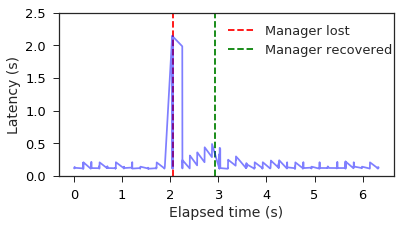

In [35]:
font = {#'family' : 'normal',                                                                                                                                                                                                              
        #'weight' : 'bold',                                                                                                                                                                                                                    
            'size'   : 14}

matplotlib.rc('font', **font)

"""
f, jobs    = plt.subplots(1, sharex=True)
# plt.legend(loc=0, ncol=2,  fancybox=1, framealpha=0.8)
launched     = jobs.hlines(range(0, len(tasks)) ,
                           [tasks[x]['submitted'] for x in tasks],
                           [tasks[x]['completed'] for x in tasks],
                           label='Submitted',
                           colors='#4166f5',
                           antialiased=True,
                           linewidth=3.0)

retried     = jobs.hlines(range(0, len(tasks)) ,
                           [tasks[x]['failed'] for x in tasks],
                           [tasks[x]['completed'] for x in tasks],
                           label='Retry',
                           colors='#f54166',
                           antialiased=True,
                           linewidth=3.0)
"""
import numpy as np

def moving_average(a, n=5) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


latencies = [(tasks[t]['completed'] - tasks[t]['submitted']).total_seconds() for t in tasks]

mov_avg_latencies = moving_average(latencies)

time_deltas = [(tasks[t]['submitted'] - tasks['0']['submitted']).total_seconds() for t in tasks]

fig, ax = plt.subplots(figsize=(6, 3))
ax.vlines(termination_time, 0, 2.5, color='red', label='Manager lost', linestyle='--')
ax.vlines(restart_time, 0, 2.5, color='green', label='Manager recovered', linestyle='--')
ax.plot(time_deltas, latencies, color='blue', alpha=0.5)
ax.set_xlabel('Elapsed time (s)', fontsize=14)
ax.set_ylabel('Latency (s)', fontsize=14)
ax.legend(loc='upper right', bbox_to_anchor=(1.03, 1),
          ncol=1, fancybox=0, framealpha=0.8, fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=13, labelcolor='black')
ax.set_ylim(0, 2.5)
#plt.xticks([tasks[t]['submitted'] for t in tasks][::20], 
           #[tasks[t]['submitted'] for t in tasks][::20], rotation='vertical')
print("Done")
plt.savefig('png/fault-tolerance.png', bbox_inches = "tight", dpi=1000)


In [9]:
latencies = [(tasks[t]['completed'] - tasks[t]['submitted']).total_seconds() for t in tasks]
print(len(latencies))
print(latencies[0]+mov_avg_latencies)+latencies[-1])

SyntaxError: invalid syntax (<ipython-input-9-98a827fb5475>, line 3)